# Training U-Net model
## 250 Epochs, No Dropout, Adam Optimizer, Learning Rate 1e-5

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet

Using TensorFlow backend.


In [2]:
from keras import utils
train_dir = "/home/ubuntu/trainingdata/TrainingSet"
weight_file = 'saved_models/endo_models/weights-250Epochs-NoDrop-Adam5.hdf5'
save_imgs_dir = 'images/train250NoDrpAdam5'

images = []
inner_masks = []
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks
    outer_masks += imgdata.epi_masks

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

def normalize(x, epsilon=1e-7, axis=(1,2)):
    x -= np.mean(x, axis=axis, keepdims=True)
    x /= np.std(x, axis=axis, keepdims=True) + epsilon
    
normalize(images,axis=(1,2))

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))

There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [3]:
height,width,_ = images[0].shape
dropout = 0.0
unet_conv = unet.UNet()

model = unet_conv.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 216, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 216, 256, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 216, 256, 32)  0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 216, 256, 32)  0           activation_1[0][0]               
___________________________________________________________________________________________

In [4]:
from keras.optimizers import Adam, SGD
from keras import backend as K

def dice_coef(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    intersection = K.sum(flat_y_true * flat_y_pred)
    return (2. * intersection + 1.) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + 1.)

def dice_coef_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)


def pixelwise_crossentropy(y_true, y_pred, weights=[0.5,0.5], epsilon=1e-8):
    ndim = K.ndim(y_pred)
    ncategory = K.int_shape(y_pred)[-1]
    # scale predictions so class probabilities of each pixel sum to 1
    y_pred /= K.sum(y_pred, axis=(ndim-1), keepdims=True)
    y_pred = K.clip(y_pred, epsilon, 1-epsilon)
    w = K.constant(weights) * (ncategory / sum(weights))
    # first, average over all axis except classes
    cross_entropies = -K.mean(y_true * K.log(y_pred), axis=tuple(range(ndim-1)))
    return K.sum(w * cross_entropies)


def show_plots(history):    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    savefig(os.path.join(save_imgs_dir,"acc-loss-plot.png"))
model.compile(optimizer=Adam(lr=1e-5),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 78

validation_split=0.2

epochs = 250
batch_size = 32


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.05,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


#seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [8]:
checkpointer = ModelCheckpoint(filepath=weight_file, verbose=1, save_best_only=True)

hist = model.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)

Epoch 1/250
7/7 [==============================] - 11s - loss: 0.6913 - dice_coef: 0.5011 - val_loss: 0.6902 - val_dice_coef: 0.5015
Epoch 2/250
7/7 [==============================] - 10s - loss: 0.6896 - dice_coef: 0.5018 - val_loss: 0.6884 - val_dice_coef: 0.5024
Epoch 3/250
7/7 [==============================] - 10s - loss: 0.6873 - dice_coef: 0.5029 - val_loss: 0.6856 - val_dice_coef: 0.5038
Epoch 4/250
7/7 [==============================] - 10s - loss: 0.6839 - dice_coef: 0.5047 - val_loss: 0.6807 - val_dice_coef: 0.5063
Epoch 5/250
7/7 [==============================] - 10s - loss: 0.6774 - dice_coef: 0.5080 - val_loss: 0.6720 - val_dice_coef: 0.5107
Epoch 6/250
7/7 [==============================] - 10s - loss: 0.6658 - dice_coef: 0.5139 - val_loss: 0.6559 - val_dice_coef: 0.5191
Epoch 7/250
7/7 [==============================] - 11s - loss: 0.6453 - dice_coef: 0.5248 - val_loss: 0.6259 - val_dice_coef: 0.5352
Epoch 8/250
7/7 [==============================] - 11s - loss: 0.6058

In [9]:
import tensorflow as tf

model.load_weights(weight_file)

def calculate_dice(images, masks_true):
    dices = []
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true.astype('float64')
        y_pred = mask_pred.astype('float64')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [11]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_inner_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_inner_masks)

Training Statistics(No Dropout)...
Dice Average: 0.93 Dice Stdev: 0.03
Validation Statistics(No Dropout)...
Dice Average: 0.94 Dice Stdev: 0.03


# View Predictions on Validation Set

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


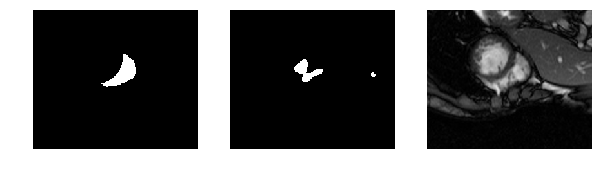

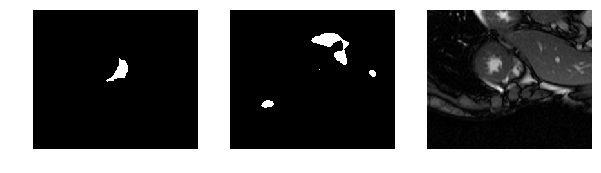

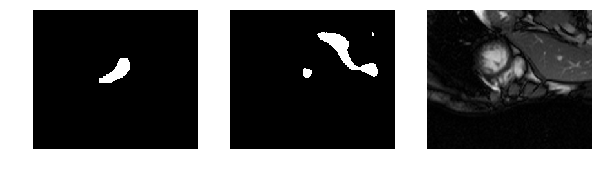

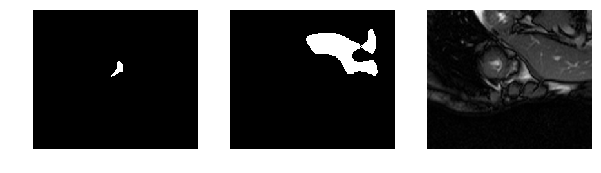

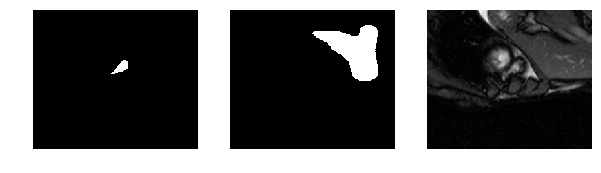

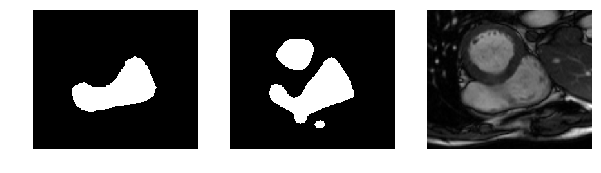

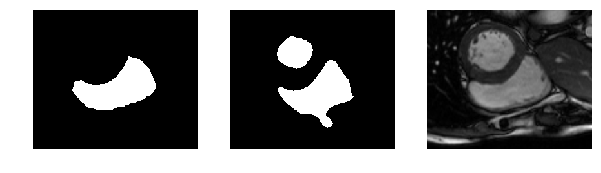

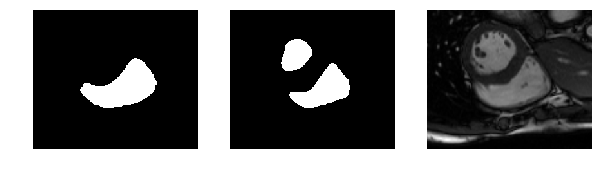

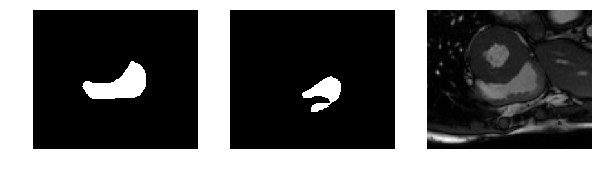

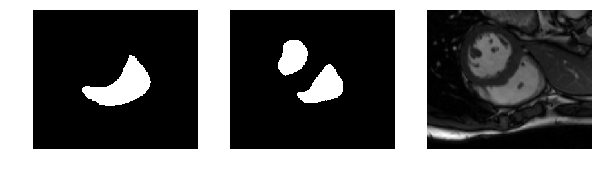

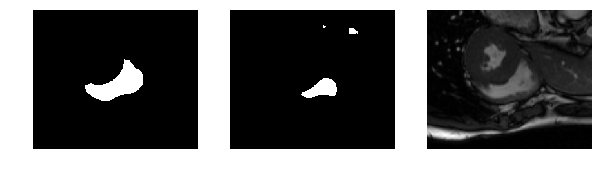

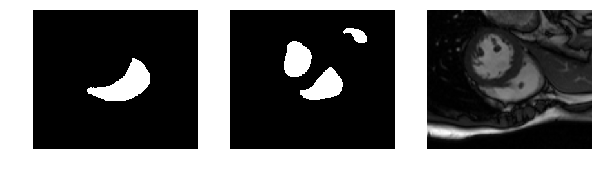

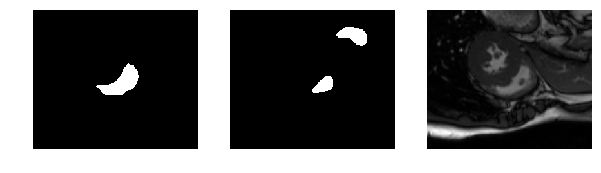

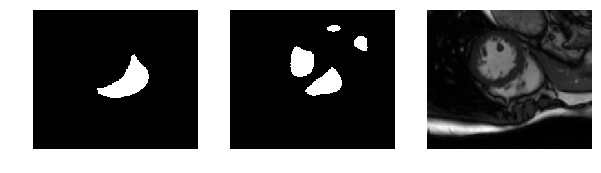

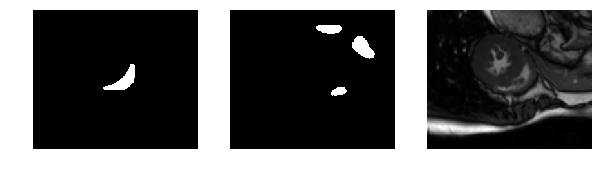

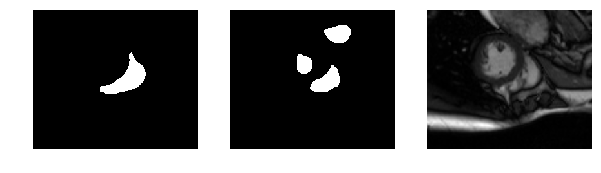

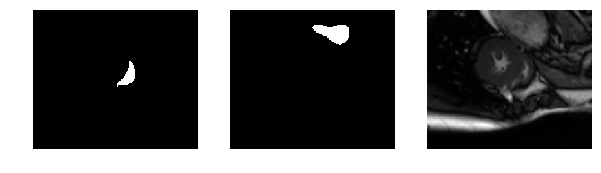

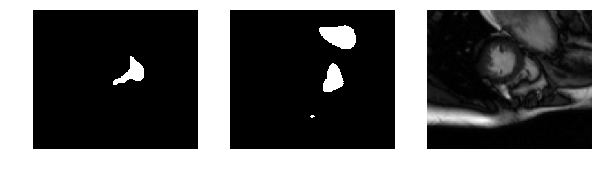

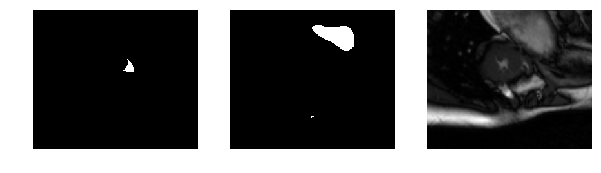

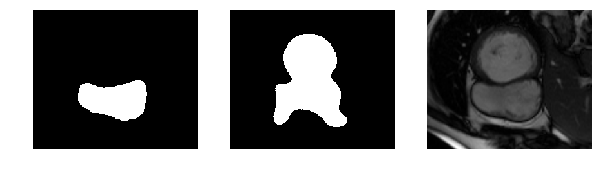

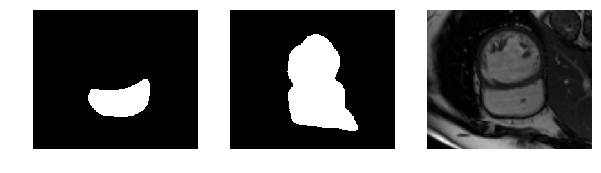

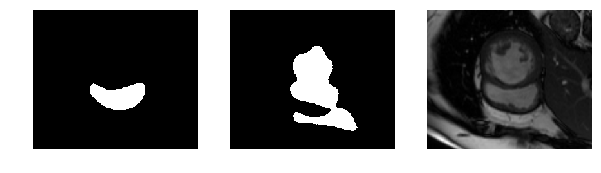

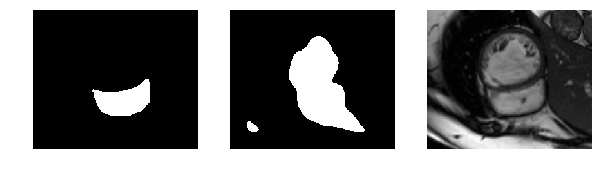

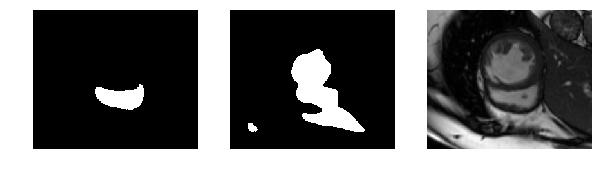

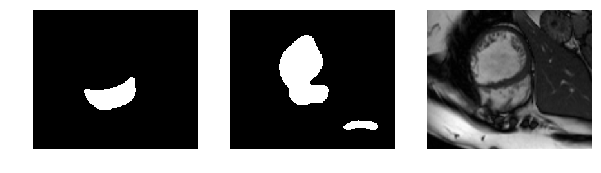

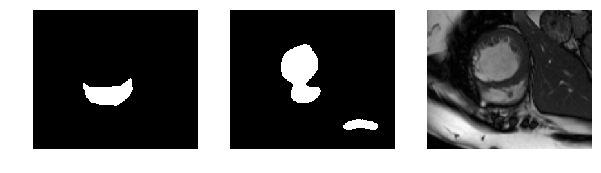

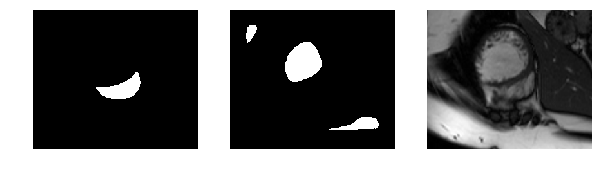

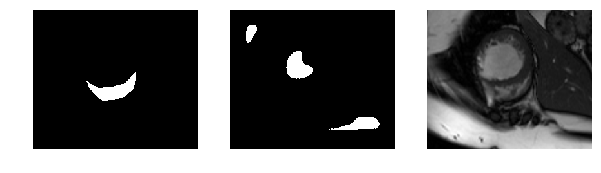

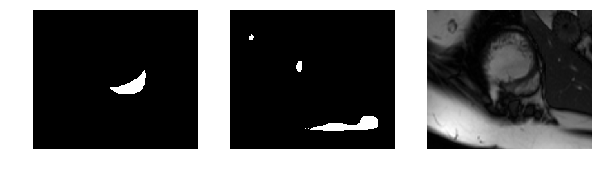

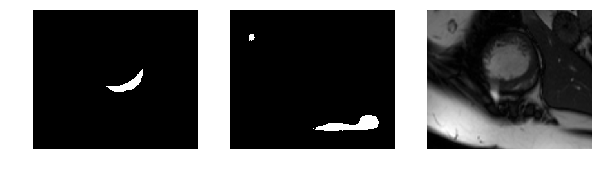

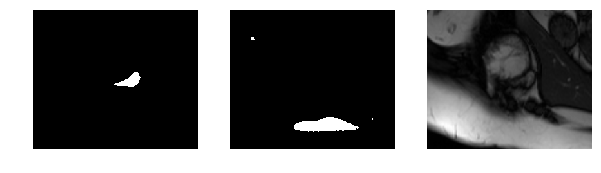

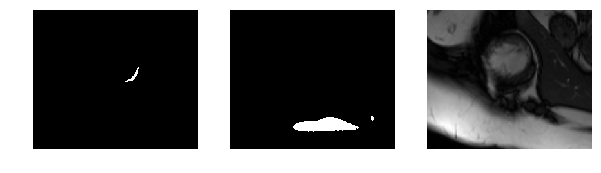

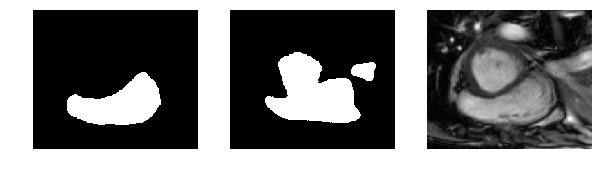

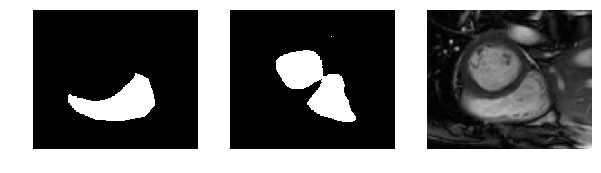

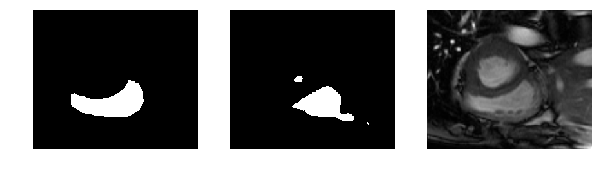

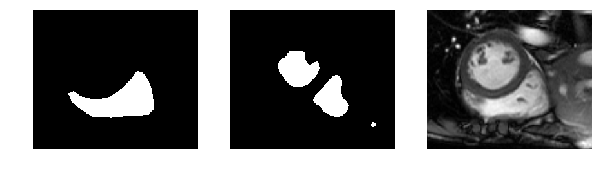

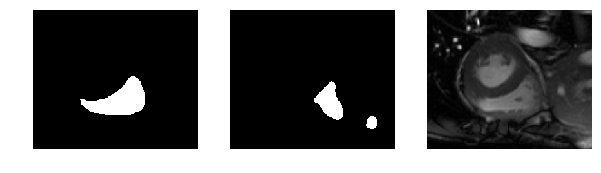

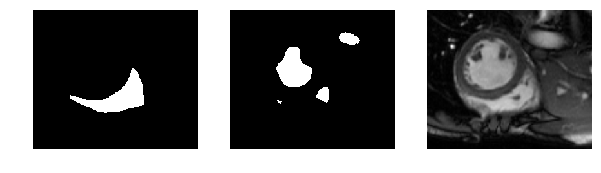

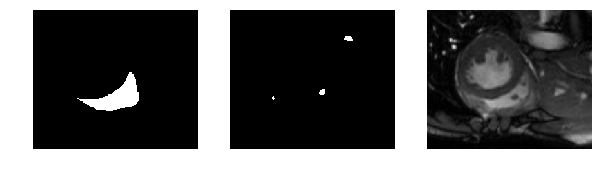

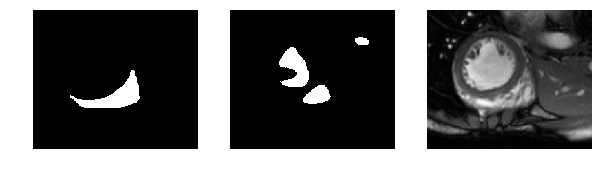

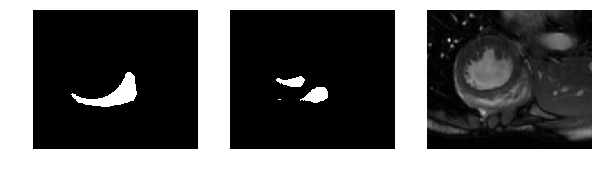

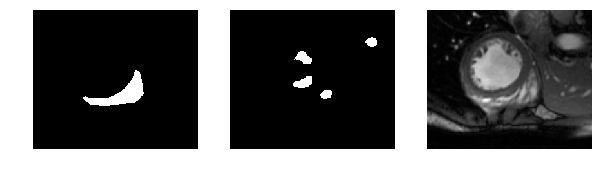

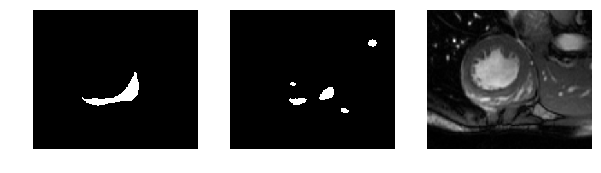

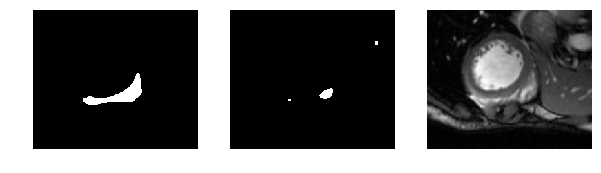

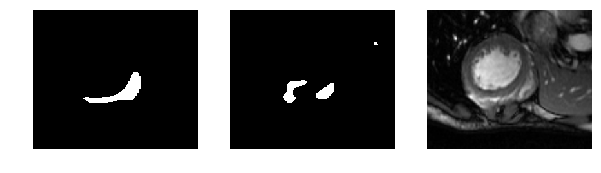

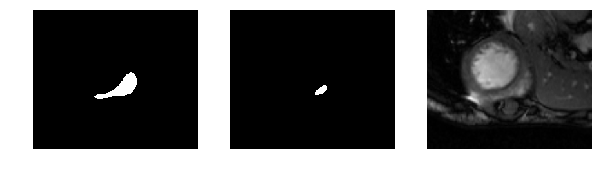

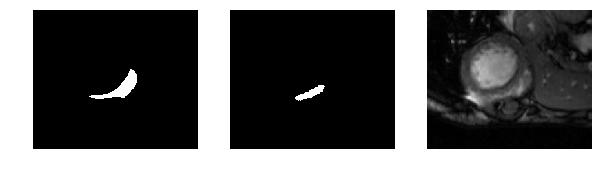

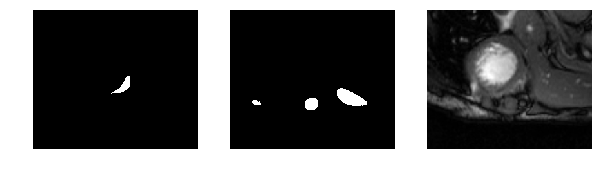

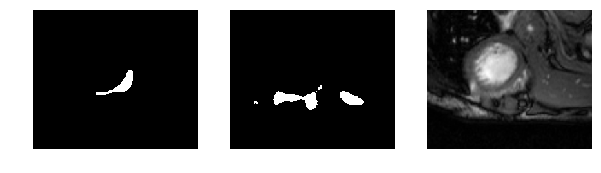

In [20]:
def show_masks(images, i_masks_true):
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.where(mask_pred[:,:,1]>0.25,255,0),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir, filename))
        
show_masks(images[split_index:], inner_masks[split_index:])